## Libraries

In [35]:
import json
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

### Load the COCO classes JSON file

In [36]:
with open('../assets/coco_classes.json') as f:
    coco_classes = json.load(f)['objects']
coco_classes = {obj['id']: obj['name'] for obj in coco_classes}
print(coco_classes)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

### Create a multiclass segmentation mask

In [37]:
def create_multiclass_mask(base_dir: str, output_dir: str, class_dict: dict, image_size=(512, 512)):
    """
    Create a multiclass segmentation mask from binary masks in the COCO format.
    
    Parameters:
        base_dir : str
            Path to the directory containing the binary masks for each class.
            The directory should have one subdirectory for each class, with the class ID as the directory name.
            The binary masks should be PNG images with the same name as the corresponding image file.
            The binary masks should have values of 0 or 255.
        output_dir : str
            Path to the output directory where the multiclass masks will be saved.
        image_size : tuple, optional
            Size of the output multiclass masks. The default is (512, 512).
        class_dict: dict, optional
         
    """

    # Create output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)

    # List all image files across all subdirectories in the base directory
    image_files = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.png'):
                image_files.append(file)

    for image_file in tqdm(image_files, desc="Processing images"):
        multiclass_mask = np.zeros(image_size, dtype=np.uint8)
        for class_id in class_dict.keys():
            if class_id == 0:  # Not considering the background class
                continue

            class_dir = os.path.join(base_dir, str(class_id))
            if not os.path.exists(class_dir):
                continue

            mask_path = os.path.join(class_dir, image_file)
            if not os.path.exists(mask_path):
                continue

                # Load binary mask and resize
            binary_mask = np.array(Image.open(mask_path).convert('L').resize(image_size))

            # Add the binary mask to the multiclass mask
            multiclass_mask[binary_mask > 127] = class_id

        # Save the multiclass mask
        output_path = os.path.join(output_dir, image_file)
        Image.fromarray(multiclass_mask).save(output_path)

In [38]:
# Usage example
data_dir = '/media/tiagociiic/easystore/RORD/debug/mask'
out_dir = '/media/tiagociiic/easystore/RORD/debug/multiclass_mask'
create_multiclass_mask(base_dir=data_dir, output_dir=out_dir, class_dict=coco_classes, image_size=(512, 512))

Processing images: 100%|██████████| 10/10 [00:00<00:00, 96.70it/s]


### Display a random multiclass segmentation mask

Number of multiclass masks created: 10
Mask shape: (512, 512), max value: 1, min value: 0


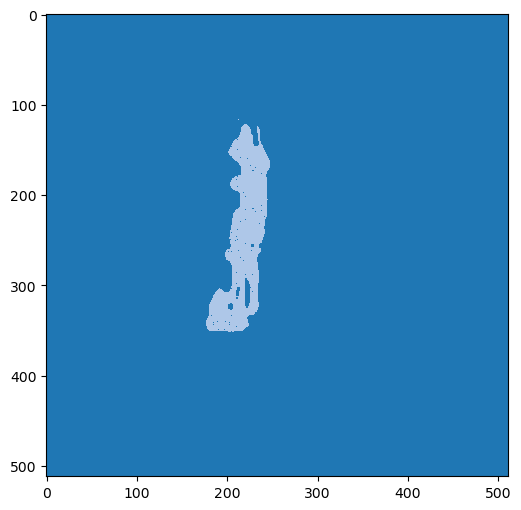

In [42]:
print(f"Number of multiclass masks created: {len(glob(out_dir + '/*.png'))}")
# plot a random mask from the output directory with color-coded COCO classes
rnd_mask_path = np.random.choice(glob(out_dir + '/*.png'))
mask = Image.open(rnd_mask_path)
mask = np.array(mask)
print(f"Mask shape: {mask.shape}, max value: {mask.max()}, min value: {mask.min()}")
plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap='tab20', vmin=0, vmax=20)
plt.show()